In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os
import time
import pandas as pd
import numpy as np

import mne
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.decoding import GeneralizingEstimator, SlidingEstimator, cross_val_multiscore

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, KMeans

from scipy.stats import spearmanr

import multiprocess as mp
import dill
# Required for multiprocess to work in Jupyter notebook
dill.settings['recurse'] = True

from functools import partial

import spacy

In [27]:
T_LIMIT = None

def cutoff(n_times):
    if T_LIMIT:
        return min(n_times, T_LIMIT)
    else:
        return n_times

In [4]:
@ignore_warnings(category=ConvergenceWarning) # So scikit wont print thousands of convergence warnings
def get_perf_timecourse(X, y, decoder, perf_metric, n_splits=5):
    n_times = X.shape[-1]
    scores = np.zeros(n_times)
    kf = StratifiedKFold(n_splits, shuffle=True)
    
    for t in range(cutoff(n_times)):
        t_scores = []

        for train_indices, test_indices in kf.split(X, y):
            decoder = decoder.fit(X[train_indices, :, t], y[train_indices])
            y_pred = decoder.predict_proba(X[test_indices, :, t])[:,1]

            score = perf_metric(y[test_indices], y_pred)
            #acc = decoder.score(X[train_indices, :, t], y[train_indices])
            t_scores.append(score)
        
        scores[t] = sum(t_scores) / len(t_scores)

        print(f"Score is {round(scores[t], 3)} at t={t}", end="\r")

    return scores


In [5]:
def as_df(x, y):
    return pd.DataFrame({'x': x, 'y': y})

In [6]:
nlp = spacy.load('en_core_web_sm')

def get_pos(sentence):
    words = sentence.split(' ')
    doc = nlp(sentence)
    pos = []
    
    i = -1
    
    for token in doc:
        in_current_word = token.text in words[i]
        
        if i + 1 < len(words):
            in_current_word = in_current_word and token.text not in words[i + 1]
        
        if in_current_word and i > 0:
            pos[i] = token.pos_
        else:
            i += 1
            pos.append(token.pos_)

    return pos

def get_pos_col(word_info):
    full_text = ' '.join(word_info['word'].tolist())
    return pd.Series(get_pos(full_text))
    # sentences = word_info.groupby(["wav_file", "sentence_number"])["word"].agg(lambda words: ' '.join(words))
    # # Get POS and flatten grouped values into a list
    # pos = np.concatenate(sentences.apply(get_pos).values)
    # return pos

def get_data(sub_id, segment='phoneme'):
    fif_name = 'start_phoneme_-1000_-1000_dcm10_BLNone_hpf60_rep0-epo.fif'
    features = ['phoneme', 'phonation', 'manner', 'place', 'frontback', 'roundness', 'centrality']
    
    if segment == 'word':
        fif_name = 'start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo.fif'
        features = ['pos']

    base_path = f'./story_sub_data/{sub_id}/{segment}_epochs'

    fif = mne.read_epochs(f'{base_path}/{fif_name}')
    
    metadata = pd.read_csv(f'{base_path}/{segment}-info.csv', keep_default_na=False)

    if segment == 'word':
        metadata['pos'] = get_pos_col(metadata)
    
    stim_features = metadata[features].to_numpy()
    sub_data = fif.get_data(picks=["meg"])
    
    del fif

    return stim_features, sub_data

In [7]:
# Useful constants for the rest of the code
sub_ids = os.listdir("./story_sub_data")
# Not sure why but this subject's data isn't loading properly
sub_ids.remove("A0281")
n_subs = len(sub_ids)

initial_stim_features, initial_sub_data = get_data(sub_ids[0], segment="word")
tpoints = initial_sub_data.shape[-1]
pos_types = np.unique(initial_stim_features[:,0])

# Recordings were -1000ms to 1000ms, relative to the phoneme/word presented, collected at 161 points
t = np.linspace(-1000, 1000, tpoints)

# Helper function to get first index where condition is true
def index_of(cond):
    indices = np.where(cond)[0]
    
    if len(indices) == 0:
        return -1
    else:
        return indices[0]

# Helper for finding index of a particular point in time
def at_t(t_point):

    return index_of(t == t_point)

Reading C:\Users\isaac\Code\surp\story_sub_data\A0168\word_epochs\start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Reading C:\Users\isaac\Code\surp\story_sub_data\A0168\word_epochs\start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo-1.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
7738 matching events found
No baseline correction applied
0 projection items activated


In [11]:
initial_stim_features[:,0] == np.array(pos_types)

C:\Users\isaac\AppData\Local\Temp\ipykernel_23628\175435240.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  initial_stim_features[:,0] == np.array(pos_types)


False

In [21]:
(np.array(pos_types)[:,np.newaxis] == initial_stim_features[:,0]).sum(axis=-1)

array([ 583,  897,  422,  365,  244,  768,   23, 1500,   54,  116, 1045,
        303,  205, 1213])

In [23]:
pos_frequencies = (pos_types[:,np.newaxis] == initial_stim_features[:,0]).sum(axis=-1)
sorted_pos = pos_types[np.argsort(pos_frequencies)[::-1]]

for pos_type in sorted_pos:
    print(pos_type, (initial_stim_features[:,0] == pos_type).sum())

NOUN 1500
VERB 1213
PRON 1045
ADP 897
DET 768
ADJ 583
ADV 422
AUX 365
PROPN 303
CCONJ 244
SCONJ 205
PART 116
NUM 54
INTJ 23


In [13]:
len(pos_types)

14

In [6]:
def get_pos_scores(sub_id):    
    stim_features, sub_data = get_data(sub_id, segment='word')
    
    logistic_decoder = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    )
    
    pos = stim_features[:, 0]
    
    sub_scores = { }

    for pos_type in pos_types:
        sub_scores[pos_type] = get_perf_timecourse(sub_data, (pos == pos_type).astype(int), logistic_decoder, roc_auc_score)
    
    del pos, sub_data, stim_features

    return sub_scores

MERGED_SCORES_LOCATION = "merged_pos_scores.npy"

def save_merged_scores(merged_scores):
    np.save(MERGED_SCORES_LOCATION, merged_scores)

def load_merged_scores():
    empty = not os.path.isfile(MERGED_SCORES_LOCATION)
    merged_sub_scores = {
        pos_type: np.zeros((n_subs, tpoints)) for pos_type in pos_types
    }
    
    if not empty:
        try:
            merged_sub_scores = np.load(MERGED_SCORES_LOCATION, allow_pickle=True).item()
        except Exception:
            empty = True
            return merged_sub_scores, empty
    
    return merged_sub_scores, empty

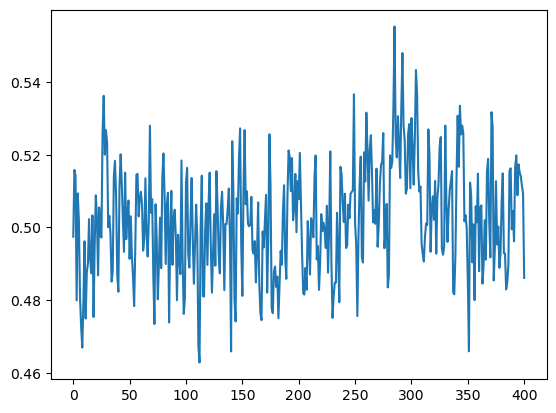

In [21]:
plt.plot(scores_a["DET"])

In [74]:
sub_ids = ["A0277"]

logistic_decoder = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

sub_scores_voicing = np.zeros((len(sub_ids), tpoints))

for i, sub_id in enumerate(sub_ids):
    stim_features, sub_data = get_data(sub_id)
    
    voicing = stim_features[:, 1]
    is_voiced = (voicing == 'v').astype(int)
    
    estimator = SlidingEstimator(logistic_decoder, n_jobs=16, scoring='roc_auc')
    validator = StratifiedKFold(n_splits=5)
    
    estimated_scores = cross_val_multiscore(estimator, X=sub_data, y=is_voiced, cv=validator)
    sub_scores_voicing[i] = estimated_scores.mean(axis=0)

Reading C:\Users\isaac\Code\surp\story_sub_data\A0277\phoneme_epochs\start_phoneme_-1000_-1000_dcm10_BLNone_hpf60_rep0-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Reading C:\Users\isaac\Code\surp\story_sub_data\A0277\phoneme_epochs\start_phoneme_-1000_-1000_dcm10_BLNone_hpf60_rep0-epo-1.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Reading C:\Users\isaac\Code\surp\story_sub_data\A0277\phoneme_epochs\start_phoneme_-1000_-1000_dcm10_BLNone_hpf60_rep0-epo-2.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
26954 matching events found
No baseline correction applied
0 projection items activated


  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

ValueError: could not broadcast input array from shape (201,) into shape (401,)

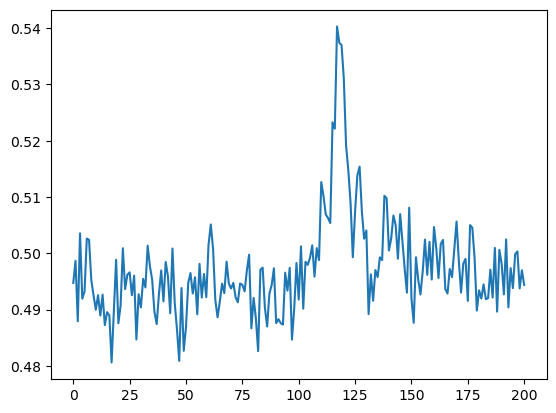

In [75]:
plt.plot(estimated_scores.mean(axis=0))

In [37]:
N_THREADS = 8
pos_types = ["DET"]


def get_pos_scores(sub_id, segment="word", feature=0, classes=None):
    logistic_decoder = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=1)
    )

    estimator = SlidingEstimator(logistic_decoder, n_jobs=-1, scoring='roc_auc') # check whether this can be here
    validator = StratifiedKFold(n_splits=5)

    stim_features, sub_data = get_data(sub_id, segment="word")
    labels = stim_features[:, feature]

    if classes is None:
        classes = np.unique(labels)

        # If it's already a binary classification problem, we only need to check for one class
        if len(classes) == 2:
            classes = classes[:1]
    
    sub_scores = { }

    for cl in classes:
        binary_labels = (labels == cl).astype(int)
        slice = cutoff(sub_data.shape[-1])
        estimated_scores = cross_val_multiscore(estimator, X=sub_data[:,:,:slice], y=binary_labels, cv=validator)
        sub_scores[cl] = estimated_scores.mean(axis=0)  

    return sub_scores

def time_proc(proc, trials=1):
    outs = []
    times = np.zeros(trials)
    
    for trial in range(trials): 
        start = time.time()
        
        out = proc()
        
        end = time.time()
        elapsed = end - start
        
        outs.append(out)
        times[trial] = elapsed
        print(f"Took {elapsed}s")

    return outs, times


def test_get_scores_se():
    outputs = []
    
    for sub_id in sub_ids:
        sub_scores = get_pos_scores(sub_id, classes=["NOUN"])
        outputs.append(sub_scores)

    return outputs
    
#se_sub_scores, se_times = time_proc(test_get_scores_se, trials=1)

In [38]:
sub_scores = get_pos_scores("A0242", classes=["NOUN"])

Reading C:\Users\isaac\Code\surp\story_sub_data\A0242\word_epochs\start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Reading C:\Users\isaac\Code\surp\story_sub_data\A0242\word_epochs\start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo-1.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
7738 matching events found
No baseline correction applied
0 projection items activated


  0%|          | Fitting SlidingEstimator : 0/401 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/401 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/401 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/401 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/401 [00:00<?,       ?it/s]

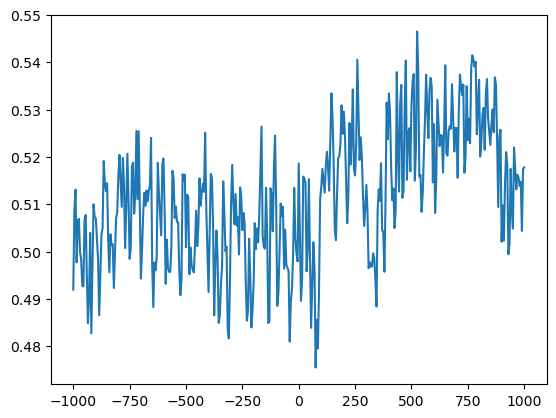

In [39]:
plt.plot(t, sub_scores["NOUN"])

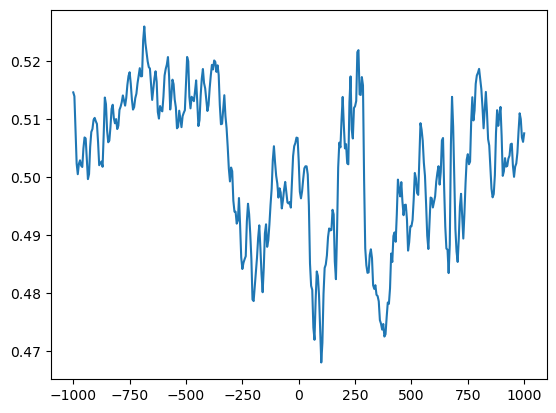

In [36]:
plt.plot(t, sub_scores["NOUN"])

In [ ]:
def test_get_scores_std():
    try:
        pool = mp.Pool(N_THREADS)
        output = pool.map(get_pos_scores, sub_ids)
    except KeyboardInterrupt as e:
        pass
    finally:
        pool.terminate()
        pool.join()

time_proc(test_get_scores_std, trials=1)

In [ ]:
merged_sub_scores, empty = load_merged_scores()

# If merged scores have not already been saved, generate them (this takes a long time)
if empty:
    output = []

    try:
        #pool = mp.Pool(4)
        #output = pool.map(get_pos_scores, sub_ids)
        for sub_id in sub_ids:
            output.append(get_pos_scores(sub_id))

    except KeyboardInterrupt as e:
        pass
    finally:
        pool.terminate()
        pool.join()

    for i in range(n_subs):
        for pos_type in pos_types:
            merged_sub_scores[pos_type][i] = output[i][pos_type]
            
    save_merged_scores(merged_sub_scores)

In [135]:
for i in range(n_subs):
    for pos_type in pos_types:
        merged_sub_scores[pos_type][i] = output[i][pos_type]
        
save_merged_scores(merged_sub_scores)

In [ ]:
get_data("A0281", segment="word")

Text(0, 0.5, 'AUC')

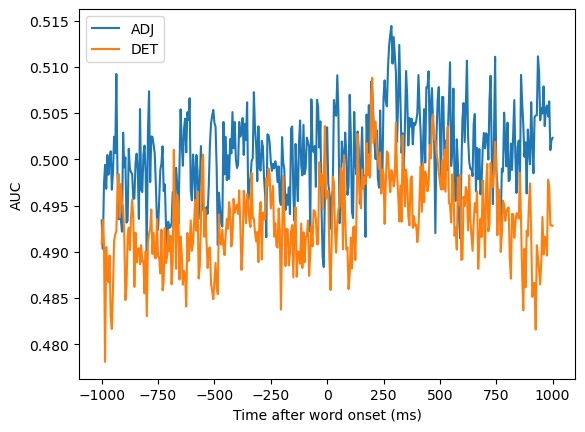

In [142]:
plt.plot(t, merged_sub_scores['ADJ'].mean(axis=0), label="ADJ")
plt.plot(t, merged_sub_scores['DET'].mean(axis=0), label="DET")
plt.legend()
plt.xlabel("Time after word onset (ms)")
plt.ylabel("AUC")

In [145]:
metadata['pos']

for pos_type in metadata['pos'].unique():
    print(pos_type, len(metadata[metadata['pos'] == pos_type].index)/len(metadata.index))

PROPN 0.03928663737399845
ADP 0.1160506590850349
INTJ 0.0029723442750064616
PRON 0.13504781597311966
VERB 0.15688808477642802
DET 0.09925045231325924
NOUN 0.19371930731455156
ADJ 0.07521323339364176
PART 0.014990953734815198
CCONJ 0.03153269578702507
SCONJ 0.026363401395709484
AUX 0.04704057896097183
NUM 0.00697854742827604
ADV 0.05453605582837943
PRON-AUX 0.00012923235978288964


Text(0, 0.5, 'AUC')

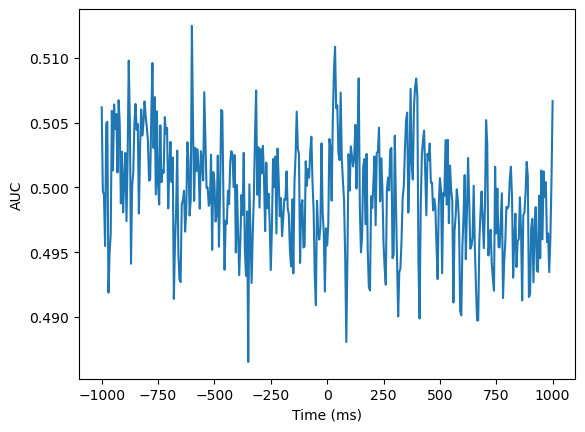

In [30]:
plt.plot(t, merged_sub_scores['ADJ'].mean(axis=0))
plt.xlabel("Time (ms)")
plt.ylabel("AUC")

In [35]:
np.argmax(merged_sub_scores['ADJ'], axis=0)

array([ 3,  3, 10,  0, 13, 14, 14, 16, 16,  6, 15, 15,  8, 15, 15,  3, 14,
       14, 13, 14, 13, 13,  8, 15, 15, 15, 15, 11, 11, 11,  2,  2, 13, 13,
       13, 10, 13, 13,  8,  9, 15,  3,  9,  9,  5, 10, 11, 12, 12, 16, 11,
       10, 12,  7, 12,  2,  2,  4,  0,  3,  2,  7,  7, 14,  9, 10,  6,  9,
       11, 15, 15,  2, 16,  9,  0,  8,  8, 11,  6,  8,  8,  6,  6, 15,  7,
       12, 14,  3,  5, 16,  7,  0, 16, 16,  7, 11, 11, 12, 16, 15,  5,  2,
        2, 16,  9,  9,  3, 16, 11,  2,  2,  7, 11, 11,  2,  8,  0, 14,  2,
        2,  2,  2,  2,  2, 16, 16,  2, 15,  6,  6, 16, 11, 11,  7, 16, 12,
       10,  2, 15,  2,  8,  3,  2,  2,  0,  0, 11,  6, 16, 15,  2,  2,  2,
        2,  2,  5,  9,  8,  1,  2,  2,  4, 12,  2,  4, 10,  2,  2,  9,  7,
        7,  9, 16, 12,  1,  2, 12, 12, 16, 12, 12,  4,  4, 16,  2, 10, 10,
       16, 15, 12,  7,  7, 12, 12,  6,  7,  7, 15,  9,  9, 13, 12,  4, 14,
       11,  4,  1, 11,  1, 16,  4, 13, 13,  9,  7, 16, 15,  9, 11,  8, 16,
       14,  9,  2,  2, 10

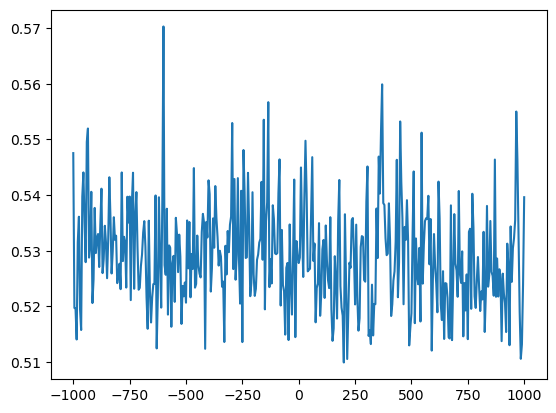

In [41]:
plt.plot(t, merged_sub_scores['ADJ'].max(axis=0))

In [56]:
# Which subject has the highest post-onset score?
np.argmax(merged_sub_scores['ADJ'][:,200:].max(axis=1))

15

In [62]:
stim_features, sub_data = get_data("A0277", segment="word")

Reading C:\Users\isaac\Code\surp\story_sub_data\A0277\word_epochs\start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Reading C:\Users\isaac\Code\surp\story_sub_data\A0277\word_epochs\start_word_-1000_-1000_dcm5_BLNone_hpf60_rep0-epo-1.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
7738 matching events found
No baseline correction applied
0 projection items activated


In [66]:
pos_types = np.unique(stim_features[:,0])

for pos in pos_types:
    print(pos, round((stim_features == pos).mean() * 100, 2), "%")

(stim_features[:,0] == 'ADP').mean()

ADJ 7.61 %
ADP 11.71 %
ADV 5.51 %
AUX 4.63 %
CCONJ 3.17 %
DET 9.73 %
INTJ 0.34 %
NOUN 19.38 %
NUM 0.7 %
PART 1.49 %
PRON 13.69 %
PRON-AUX 0.01 %
PROPN 3.72 %
SCONJ 2.47 %
VERB 15.86 %


0.11708451796329801

In [59]:
sub_ids[15]

'A0277'

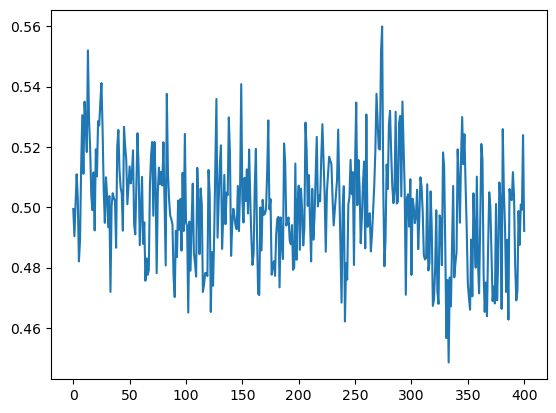

In [57]:
plt.plot(merged_sub_scores['ADJ'][15])

In [44]:
np.argmax(t == 0)

200

In [32]:
merged_sub_scores['ADJ']

array([[0.51244663, 0.50305261, 0.484405  , ..., 0.48120675, 0.49162102,
        0.51292965],
       [0.49478687, 0.48306102, 0.49534528, ..., 0.51317795, 0.51467207,
        0.51785129],
       [0.4983977 , 0.5038937 , 0.50495989, ..., 0.5048513 , 0.49673769,
        0.53175575],
       ...,
       [0.49564625, 0.50127769, 0.50789633, ..., 0.48953125, 0.50017902,
        0.53189014],
       [0.49942478, 0.49039025, 0.50066054, ..., 0.49917695, 0.52390263,
        0.4921415 ],
       [0.50390557, 0.49547133, 0.49243402, ..., 0.50001388, 0.49608017,
        0.49746096]])

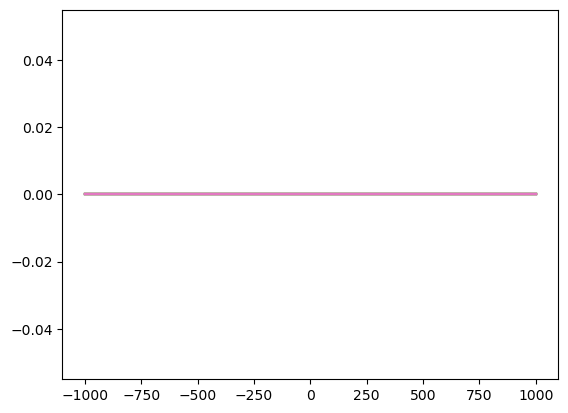

In [21]:
plt.plot(t, merged_sub_scores['ADJ'].T)

In [61]:
# Condition to be used for further analysis
CONDITION = "pure"
scores = merged_sub_scores[CONDITION]

## Dimensionality Analysis

In [43]:
#scores = np.delete(scores, [7], axis=0) - If you want to remove outlier subject

pca = PCA(n_components=10)
transformed_scores = pca.fit_transform(scores)

<Axes: >

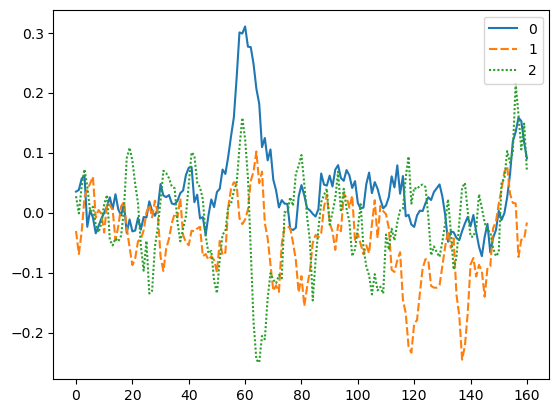

In [62]:
sns.lineplot(pca.components_[:3].T)

<Axes: >

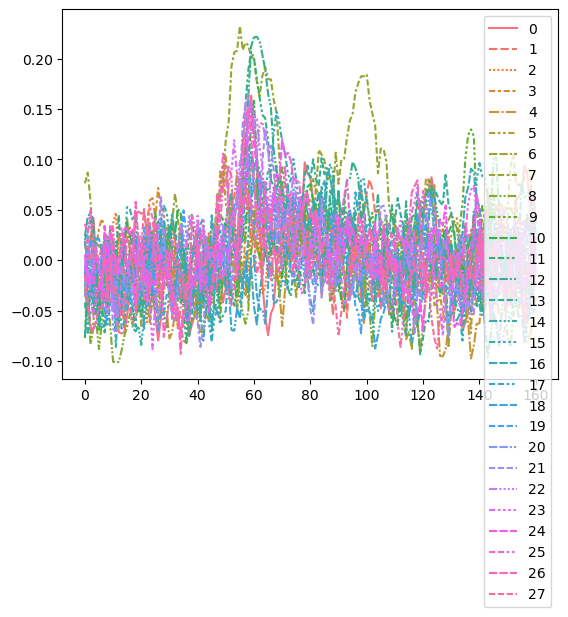

In [23]:
sns.lineplot(scores.T)

<Axes: >

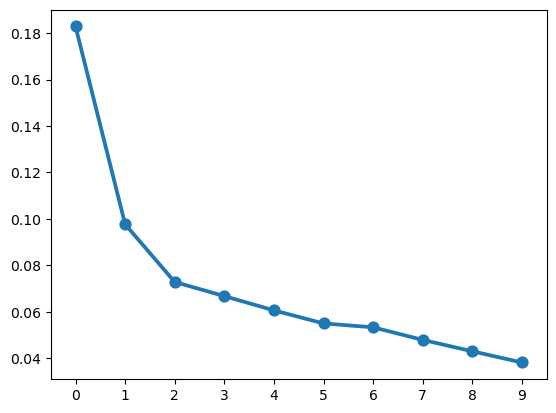

In [46]:
sns.pointplot(pca.explained_variance_ratio_)

In [ ]:
sns.lineplot((pca.transform(scores) @ pca.components_).T)

In [ ]:
mean_scores = scores.mean(axis=0)
dm_scores = (scores - scores.mean(axis=0))
sns.lineplot(dm_scores.T)

<Axes: >

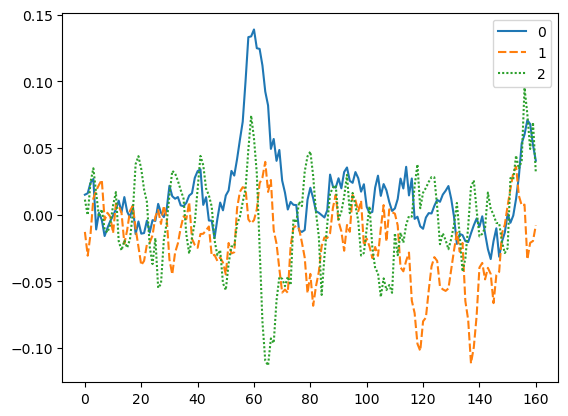

In [47]:
import skfda
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix, KNeighborsHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
from skfda.representation.grid import FDataGrid

mean_scores = scores.mean(axis=0)
dm_scores = (scores - scores.mean(axis=0))

fpca = FPCA(n_components=3)
score_grid = FDataGrid(dm_scores, grid_points=t)
fpca.fit(score_grid)

basis_fns = fpca.components_.data_matrix.squeeze()
approx = fpca.transform(score_grid) @ basis_fns
#sns.lineplot((approx + mean_scores).T)
sns.lineplot(basis_fns.T)

<Axes: >

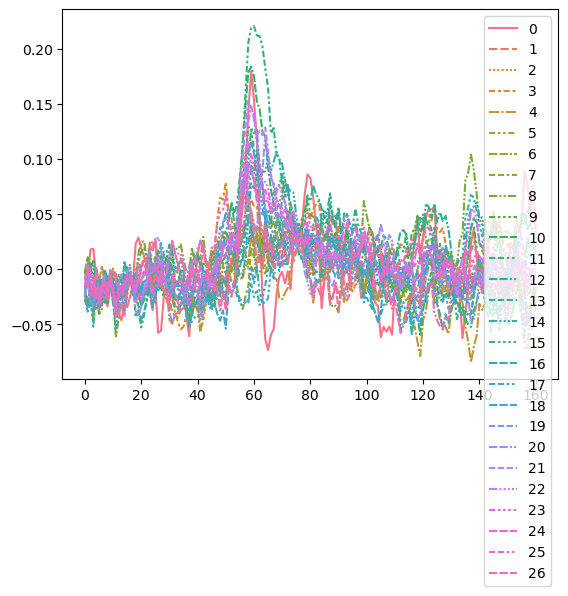

In [49]:
fpca = FPCA(n_components=5)
fpca.fit(score_grid)
basis_fns = fpca.components_.data_matrix.squeeze()
approx = fpca.fit_transform(score_grid) @ basis_fns
sns.lineplot((approx + mean_scores).T)

# t-clustering

In [ ]:
t_obs, clusters, cluster_pvs, H0 = mne.stats.permutation_cluster_1samp_test(scores, threshold=1.96)

In [ ]:
sns.lineplot(scores.T)

In [ ]:
fig, ax = plt.subplots()

avg_scores = scores.mean(axis=0)
alpha = 0.05

for cluster, pv in zip(clusters, cluster_pvs):
    if pv < alpha: 
        print(pv)
        ax.fill_between(t[cluster], avg_scores[cluster], color="tab:blue", alpha=0.5)
    
sns.lineplot(as_df(t, avg_scores), x='x', y='y', color="tab:blue", ax=ax)
sns.lineplot(as_df(t, 0), x='x', y='y', color="gray", linestyle="dashed", ax=ax)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Spearman correlation")